First, install and import necessary libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score

Then, we check the first few lines of the dataset to understand the structure of the dataset (i.e.: rows and columns, labelled or not, how many features, etc.)

In [2]:
# URL to SMS Spam Collection Dataset on Kaggle
data_filepath = '/Users/.../SMS Classifier/spam.csv'

# Read the CSV file with the correct encoding specified
sms_data = pd.read_csv(data_filepath, encoding='ISO-8859-1')

# Display the first few rows of the DataFrame
sms_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


After reviewing below the shape of the dataset and the count of the missing values in the last 3 columns, I opted to drop those columns as:
- there were too many missing values in each of the 3 columns
- after checking the 'notnull' content, I found those columns to be irrelevant for the purpose of this project

In [3]:
# Check the shape (rows and columns) of the dataset
print(sms_data.shape)

# Count the number of missing values in each column
missing_values_count = sms_data.isnull().sum()

# Display the result
print(missing_values_count)

# Create boolean masks for non-missing values in each column
mask_col2 = sms_data['Unnamed: 2'].notnull()
mask_col3 = sms_data['Unnamed: 3'].notnull()
mask_col4 = sms_data['Unnamed: 4'].notnull()

# Use the boolean masks to filter the DataFrame and extract rows with non-missing values
non_missing_values_col2 = sms_data[mask_col2]
non_missing_values_col3 = sms_data[mask_col3]
non_missing_values_col4 = sms_data[mask_col4]

# Drop the columns with too many missing values
sms_data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

(5572, 5)
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


After dropping the last 3 columns, I labelled the analytically relevant columns:
- first column(v1) changed to 'label' -- signifying the 'ham' or 'spam' labels
- second column(v2) changed to 'text' -- signifying sms or text messages
- changed the categorical data into numeric data in the 'label' column: '0' for ham, '1' for spam

In [4]:
# Rename the first two columns
sms_data.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)

# Convert categorical data into numerical values using LabelEncoder
le = LabelEncoder()
sms_data['label'] = le.fit_transform(sms_data['label'])

sms_data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Next, I have defined a funtion to tokenize each text:
- used regex to filter out non-alpha characters and white space
- used  "stopwords" and "word_tokenize" from the nltk library to filter out stopwords and tokenize the texts

In [5]:
def tokenize(sentences):
    prep = (re.sub("[^a-zA-Z\s]", "", sentences)).lower()
    prepped = word_tokenize(prep)
    filtered_sentence = [word for word in prepped if word not in stop_words]
    return filtered_sentence
stop_words = stopwords.words("english")

Below, I have built a corpus for the text messages:
- tokenized each text
-  converted the list of tokens into a list of comma-separated strings

In [6]:
corpus = []
for i in range(0, len(sms_data)):
  review = tokenize(sms_data['text'][i])
  review = ' '.join(review)
  corpus.append(review)

I have plotted the distribution of ham and spam messages below, creating a visual representation of the spread

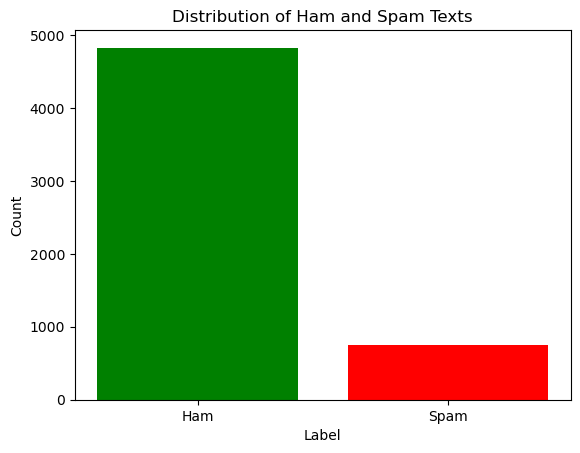

Number of ham texts: 4825
Number of spam text: 747



In [7]:
# Count the occurrences of each label
label_counts = sms_data["label"].value_counts()

# Define custom colours for "Ham" and "Spam"
colours = ['green', 'red']

# Plot the bar chart with custom colors
plt.bar(label_counts.index, label_counts.values, color=colours)

# Add labels and title
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Ham and Spam Texts")

# Customize x-axis tick labels
plt.xticks(label_counts.index, ["Ham", "Spam"])

# Show the plot
plt.show()

# Numeric representation of total hams (label = 0) and total spams (label = 1)
print(f"Number of ham texts: {label_counts[0]}\nNumber of spam text: {label_counts[1]}\n")

Here, below, I have gotten counts of the top 10 ham and top 10 spam messages.

I have plotted those top frequency words below, side by side, for ease of visual comparison.

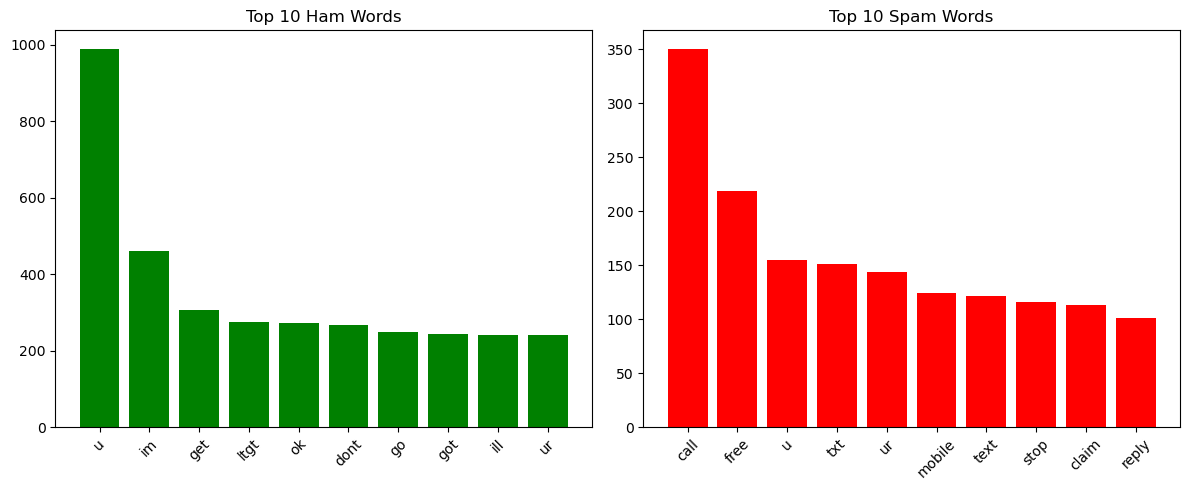

In [8]:
# Check the top 10 ham words and the top 10 spam words and show in plot
spam_messages = sms_data[sms_data["label"] == 1]["text"]
ham_messages = sms_data[sms_data["label"] == 0]["text"]

spam_words = []
for each_message in spam_messages:
    spam_words += tokenize(each_message)
    
ham_words = []
for each_message in ham_messages:
    ham_words += tokenize(each_message)
    
top_10_spams = pd.Series(spam_words).value_counts().head(10)
top_10_hams = pd.Series(ham_words).value_counts().head(10)

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the top 10 ham words
axes[0].bar(top_10_hams.index, top_10_hams.values, color='green')
axes[0].set_title("Top 10 Ham Words")
axes[0].tick_params(axis='x', rotation=45)

# Plot the top 10 spam words
axes[1].bar(top_10_spams.index, top_10_spams.values, color='red')
axes[1].set_title("Top 10 Spam Words")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlapping of titles
plt.tight_layout()

# Show the plots
plt.show()

I have:
- implemented a Bag-of-Words approach
- used a CountVectorizer with a reduced column amount of 6000
- Split the dataset into train and test sets in an 

In [9]:
# Used Bag-of-Words approach, reduced the number of features to 6000
cv = CountVectorizer(max_features = 6000)
X = cv.fit_transform(corpus).toarray()
print(X.shape)
y = sms_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(5572, 6000)


Finally, in the cell block below, I have:
- implemented a Naive Bayes classifier
- achieved an accuracy score of 0.972, i.e.: approx. 97%
- created a confusion matrix heatmap to pictorially represent the model's predictability (Predicted Labels vs True Labels)


Model accuracy:  97%



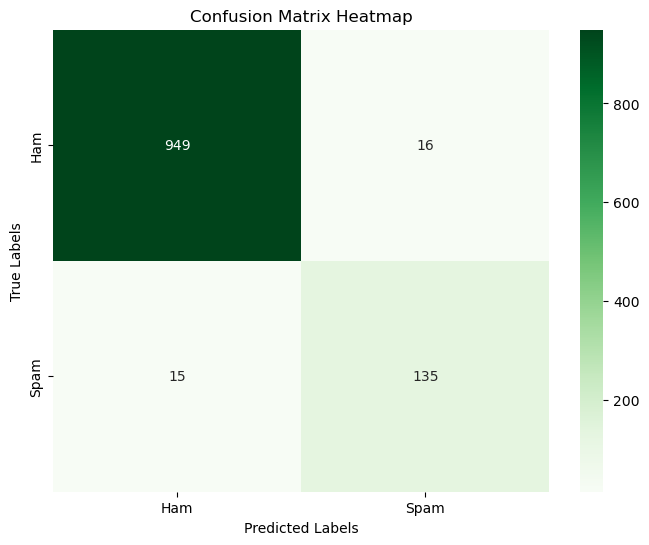

In [10]:
# Trained model using Naive Bayes classifier
spam_detector = MultinomialNB().fit(X_train, y_train)
y_pred = spam_detector.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel accuracy: {accuracy: .0%}\n")
conf_mtrx = confusion_matrix(y_test, y_pred)

# Created a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mtrx, annot=True, fmt='d', cmap='Greens', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()